# 4章 最適化問題を解く流れを理解しよう 
ここでは、巡回セールスマン問題を例に、最適化の基本的な考え方を学んでいきます。

In [ ]:
#Colaboratory環境の設定
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MathProgramming/Chapter4

In [ ]:
#ライブラリの設定
!pip install -q -r ./requirements.txt

## 4-3. 全探索を行ってみよう

倉庫の座標
[[ 9 25]
 [68 88]
 [80 49]
 [11 95]
 [53 99]
 [54 67]
 [99 15]
 [35 25]]
倉庫の位置関係


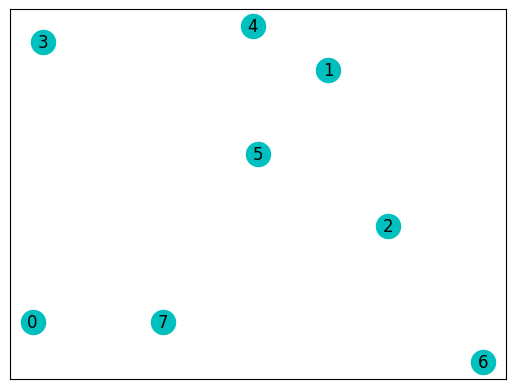

In [1]:
import numpy as np 
np.random.seed(100)
import networkx as nx 
import matplotlib.pyplot as plt 
import pandas as pd 

# 頂点数を8とする
n = 8

# 各地点の座標を読み込む
vertices = pd.read_csv('vertices.csv').values 
print('倉庫の座標')
print(vertices)

# グラフの作成
g = nx.DiGraph()

# n個の頂点をグラフに追加
g.add_nodes_from(range(n))

# 頂点座標の情報をグラフに追加しやすい形に整形
pos = dict(enumerate(zip(vertices[:, 0], vertices[:, 1])))

# グラフを描画
nx.draw_networkx(g, pos=pos, node_color='c')
print('倉庫の位置関係')
plt.show()

### 距離を求める

In [ ]:
# 頂点感の距離をマトリックスで表す
graph = np.linalg.norm(
    vertices[:, None] - vertices[None, :],
    axis=-1,
)
# graph(5, 3) は、頂点5から頂点3への距離
# graph(0, 7) は 頂点0から頂点7への距離

# わかりやすさのため小数点以下は切り捨て
graph = graph.astype(int)

print('倉庫間距離のマトリックス')
print(graph)

In [2]:
from itertools import permutations

# 始点(終点)を決める
src = 0

# 経路を全列挙(始点は除いて列挙しておく)
routes = np.array([*permutations(range(1, 8))]).T

# 経路数を出力
m = routes.shape[1] 
print(f'経路数: {m}')

# 始点を最初と最後に追加
routes = np.pad(routes, pad_width=((1,1), (0,0)), constant_values=src)
print('経路の列挙')
print(routes)

# 各経路について、総移動距離を一括で求める
dist = graph[routes[:-1], routes[1:]].sum(axis=0)
print('各経路の総移動距離')
print(dist)

経路数: 5040
経路の列挙
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 7 7 7]
 [2 2 2 ... 6 6 6]
 ...
 [6 7 5 ... 3 1 2]
 [7 6 7 ... 1 2 1]
 [0 0 0 ... 0 0 0]]


NameError: name 'graph' is not defined

In [ ]:
print(f'最短距離: {dist.min()}')

In [ ]:
# 経路を移動距離の短い順にソート
i = np.argsort(dist)
routes = routes[:, i]
dist = dist[i]
print('経路を短い順に並び替える')
print(dist)

path = routes[:, 0]
print(f'最短経路: {path}')
print(f'最短距離: {dist[0]}')

### これを可視化してみる

In [ ]:
for i in range(n):
    nx.draw_networkx(g, pos=pos, node_color='c')
    plt.show()
    g.add_edge(path[i], path[i+1])
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()


for i in range(n):
    g.remove_edge(path[i], path[i+1])

## 4-4. アルゴリズムによる問題の解き方を理解しよう 

### for文で和を求める

In [ ]:
# nを100とする
n = 100
s = sum(i for i in range(1, n+1))
print(f'和: {s}')

### 和の公式により求める

In [ ]:
n = 10
s = (1+n)*n//2 
print(f'和: {s}')

### nが大きい場合

In [ ]:
n = 10000
s = (1+n)*n//2
print(f'和: {s}')

## 4-6. 動的計画法のソースコードを理解しよう 

### Graphクラス

In [3]:
from itertools import combinations 
import pandas as pd 
import random
inf = float('inf')

class Graph:
    class Edge:
        def __init__(self, weight=1, **args):
            self.weight = weight
        
        def __repr__(self):
            return f'{self.weight}'
        
    
    def __init__(self, n):
        self.N = n
        self.edges = [{} for _ in range(n)]
    
    
    # 辺を追加
    def add_edge(self, u, v, **args):
        self.edges[u][v] = self.Edge(**args)
            
    
    @classmethod 
    def from_csv(cls, path):
        nodes = pd.read_csv(path).values
        n = nodes.shape[0]
        print(f'頂点数: {n}')
        weights = cls.weights_from_nodes(nodes)
        
        g = cls(n)
        g.generate_network(nodes)
        
        for u in range(n):
            for v in range(n):
                g.add_edge(u, v, weight=weights[u, v])                
        return  g
        
    
    @staticmethod
    def generate_nodes(n):
        nodes = np.random.randint(low=0, high=100, size=(n, 2))
        return nodes
    
    
    def generate_network(self, nodes):
        n = len(nodes)
        network = nx.DiGraph()
        network.add_nodes_from(range(n))
        pos = dict(
            enumerate(zip(nodes[:, 0], nodes[:, 1]))
        )
        nx.draw_networkx(network, pos=pos, node_color='c')
        self.network = network
        self.pos = pos 
        return network
        
    
    @staticmethod
    def weights_from_nodes(nodes):
        return np.linalg.norm(
            nodes[:, None] - nodes[None, :],
            axis=-1,
        ).astype(np.int64)

    
    # ランダムに辺を生成する関数(csv以外のパターンも作成したい場合に使用)
    def generate_edges(self):
        random.seed(0)
        for u, v in combinations(range(self.N), 2):
            weight = random.randint(1, 100)
            self.add_edge(u, v, weight=weight)
            self.add_edge(v, u, weight=weight)
        for u in range(self.N): 
            self.add_edge(u, u, weight=0)
            
            
    # ルートの総距離を計算(全探索用)
    def calculate_dist(self, route):
        n = self.N
        source = route[0]
        route += [source]
        return sum(
            self.edges[route[i]][route[i+1]].weight 
            for i in range(n)
        )

    
    def show_path(self, path):
        n = self.N
        network = self.network 
        pos = self.pos
        for i in range(n):
            network.add_edge(path[i], path[i+1])
        nx.draw_networkx(
            network, 
            pos=pos, 
            node_color='c',
        )
        plt.show()
        self.remove_edges()
    
    
    def remove_edges(self):
        network = self.network
        network.remove_edges_from(
            list(network.edges)
        )
    



In [4]:
class TSPBruteForce(Graph):
    # 全探索アルゴリズム(DPアルゴリズムとの比較用に、numpyを使わず実装)
    def __call__(self, src=0):
        n = self.N
        stack = [([src], 1<<src)]
        dist = float('inf')
        calc_count = 0
        while stack:
            route, visited = stack.pop()
            if visited == (1<<n) - 1:
                calc_count += 1
                d = self.calculate_dist(route)
                if d >= dist: continue 
                dist = d
                res_route = route

            for i in range(n):
                if i==src or visited>>i & 1: continue 
                nxt_route = route.copy()
                nxt_route.append(i)
                stack.append((nxt_route, visited|(1<<i)))
                
        print(f'計算回数: {calc_count}')
        return dist, res_route

In [5]:
class TSPDP(Graph):
    # DPアルゴリズム
    def __call__(self, src=0):
        n = self.N
        dp = [[(inf, None)] * n for _ in range(1<<n)]
        dp[1][src] = (0, None)
        calc_count = 0
        for s in range(1<<n):
            for v in range(n):
                if s>>v&1: continue
                t = s|(1<<v) # tはsにvを追加した集合
                for u in range(n):
                    if ~s>>u&1: continue
                    d = dp[s][u][0] + self.edges[u][v].weight
                    if d >= dp[t][v][0]:
                        continue
                    dp[t][v] = (d, u)
                    calc_count += 1

        print(f'計算回数: {calc_count}')

        dist = inf 
        predecessor = []
        for u in range(1, n):
            s = (1 << n) - 1
            d = dp[s][u][0] + self.edges[u][src].weight 
            if d >= dist: continue 
            dist = d 
            predecessor = [src]
            while True:
                v = u
                predecessor.append(v)
                u = dp[s][v][1]
                if u is None: break 
                s &= ~(1 << v)
        
        return dist, predecessor[::-1]

### csvからGraphを生成　

DP
頂点数: 11
全探索
頂点数: 11


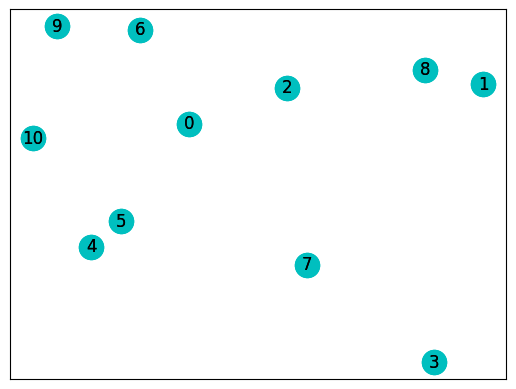

In [6]:
print('DP')
g1 = TSPDP.from_csv('4_6_nodes.csv')
print('全探索')
g2 = TSPBruteForce.from_csv('4_6_nodes.csv')

### DPにより距離とpathを求める

In [7]:
%%time
d, path = g1(src=0)
print(f'距離: {d}')
print(f'経路: {path}')

計算回数: 10633
距離: 331
経路: [0, 6, 9, 10, 4, 5, 7, 3, 1, 8, 2, 0]
CPU times: total: 31.2 ms
Wall time: 203 ms


### 全探索により距離とpathを求める

In [ ]:
%%time
d, path = g2(src=0)
print(f'距離: {d}')
print(f'経路: {path}')

### pathを可視化する

In [ ]:
g2.show_path(path)

## 4-8. 最近傍法によって近似解を求めよう 

### 最近傍法でTSPを解くクラス

In [ ]:
class TSPNearestNeighbour(Graph):
    def __call__(self, src=0):
        n = self.N
        visited = [False] * n 
        visited[0] = True 
        dist = 0
        u = src # 一つ前の頂点
        path = [src]
        calc_count = 0
        for _ in range(n-1):
            cand = []
            for v in range(n): # 次に訪れる頂点
                calc_count += 1
                if visited[v]: continue
                cand.append((v, dist + self.edges[u][v].weight))

            cand.sort(key=lambda x: x[1])
            u, dist = cand[0] # 最も近い頂点へ移動
            visited[u] = True
            path.append(u)
        path.append(src)
        print(f'計算回数: {calc_count}')
        
        return dist + self.edges[u][src].weight, path

### csvからGraphを読み込む

In [ ]:
print('最近傍法')
g = TSPNearestNeighbour.from_csv('4_8_nodes.csv')
print('DP')
g2 = TSPDP.from_csv('4_8_nodes.csv')

### 最近傍法により距離とpathを求める

In [ ]:
%%time
d, path = g(src=0)
print(f'距離: {d}')
print(f'経路: {path}')
g.show_path(path)

### DPにより距離とpathを求める

In [ ]:
%%time 
d2, path = g2(src=0)
print(f'距離: {d2}')
print(f'経路: {path}')
g.show_path(path)

### 距離の相対誤差を求める

In [ ]:
print(f'相対誤差: {(d-d2)/d2}')

### 最近傍法による探索の様子を可視化する

In [ ]:
import numpy as np 
np.random.seed(100)
import networkx as nx 
import matplotlib.pyplot as plt 

n = 8
vertices = np.random.randint(1, 100, (n, 2))
g = nx.DiGraph()
g.add_nodes_from(range(n))
pos = dict(enumerate(zip(vertices[:, 0], vertices[:, 1])))
print('倉庫の位置関係')
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()

In [ ]:
dist = vertices[:,None] - vertices[None, :]
dist = np.sqrt((dist**2).sum(axis=-1)).astype(int)
print('倉庫間距離のマトリックス')
print(dist)

graph = TSPNearestNeighbour(n)
for i in range(n):
    for j in range(n):
        graph.add_edge(i, j, weight=dist[i,j])

In [ ]:
d, path = graph(src=0)
n = len(path) - 1
for i in range(n):
    
    nx.draw_networkx(g, pos=pos, node_color='c')
    plt.show()
    g.add_edge(path[i], path[i+1])
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()

for i in range(n):
    g.remove_edge(path[i], path[i+1])


## 4-10. 遺伝アルゴリズムのソースコードを理解しよう 

In [ ]:
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx

### GAによるTSPのソルバークラス

In [ ]:
# 今回は、便宜上始点と終点を0に固定します。
class GATSP:
    def __init__(self, n=10):
        self.N = n
    
    def generate_nodes(self):
        np.random.seed(0)
        self.nodes = np.random.uniform(size=(self.N, 2))
        self._dist = np.linalg.norm(
            self.nodes[:,None] - self.nodes[None,:], 
            axis=-1,
        )

    
    @classmethod
    def from_csv(cls, path):
        nodes = pd.read_csv(path).values
        n = nodes.shape[0]
        tsp = cls(n)
        tsp._dist = np.linalg.norm(
            nodes[:,None] - nodes[None,:], 
            axis=-1,
        )
        tsp.nodes = nodes
        return tsp


    def generate_route(self):
        return np.random.permutation(np.arange(1, self.N))
    
    @staticmethod 
    def routes_from_csv(path):
        routes = pd.read_csv(path).values
        return routes
        
        
    def init_routes(self, m=100):
        routes = np.array([self.generate_route() for _ in range(m)])
        return np.pad(routes, pad_width=((0,0), (1,0)), constant_values=0)
    
    
    def dist(self,routes):
        routes = np.pad(routes, pad_width=((0,0), (0,1)), constant_values=0)
        return self._dist[routes[:,:-1],routes[:,1:]].sum(axis=1)
    
    
    def fitness(self, routes): return 1/self.dist(routes)
    
    
    def select_parents(self, routes, m=None):
        if m is None: m = routes.shape[0]//2
        assert 2*m <= routes.shape[0]
        f = self.fitness(routes)
        p = f/f.sum()
        pair = np.random.choice(routes.shape[0], (m, 2), replace=True, p=p)
        i = np.argsort(routes, axis=1)
        return routes[pair], i[pair] 
    
    def crossover(self, routes, m=None):
        if m is None: m = routes.shape[0]//2
        parents, i = self.select_parents(routes, m)
        for j in range(m): # ペアごとに交叉
            k = np.random.randint(1,self.N-1)
            parents[j,np.arange(2),i[j,np.arange(2),parents[j,::-1,k]]], parents[j,:,k] \
            = parents[j,:,k], parents[j,np.arange(2),i[j,np.arange(2),parents[j,::-1,k]]]
        childs = parents.reshape(-1, self.N)
        return childs

    def mutate(self, routes, p=0.7):
        m = routes.shape[0]
        bl = np.random.choice((0,1), m, replace=True, p=(1-p, p)).astype(bool) #突然変異を起こす確率を指定
        k = np.arange(m)[bl]
        i, j = np.random.randint(1, self.N-1, (m, 2))[bl].T
        routes[k,i], routes[k,j] = routes[k,j], routes[k,i]
        return routes
        
        
    def extract_elites(self, routes, elite_cnt):
        return routes[np.argsort(self.fitness(routes))[-elite_cnt:]]

    
    def generate_nxt(self, routes, elite_cnt=2):
        elites = self.extract_elites(routes, elite_cnt)
        childs = self.crossover(routes, m=(routes.shape[0]-elite_cnt)//2)
        childs = self.mutate(childs)
        return np.vstack([elites, childs])
    
    
    def show(self, routes):
        path = list(routes[np.argsort(tsp.dist(routes))][0])+[0]
        plt.figure(figsize=(15,10))
        g = nx.DiGraph()
        g.add_nodes_from(range(n))
        pos = dict(enumerate(zip(tsp.nodes[:, 0], tsp.nodes[:, 1])))
        nx.draw_networkx(g, pos=pos, node_color='c')
        for i in range(len(path)-1):
            g.add_edge(path[i], path[i+1])
        nx.draw_networkx(g, pos=pos, node_color='c')
        plt.show()
        plt.clf()


### 倉庫(nodes)の座標をcsvから読み込み、ソルバーインスタンスを生成

In [ ]:
tsp = GATSP.from_csv('4_10_nodes.csv') 
n = len(tsp.nodes)
routes = tsp.routes_from_csv('4_10_routes.csv')
print('第0世代の経路群')
print(routes)

### 遺伝的アルゴリズムを適応
1000世代ごとに最短経路を出力

In [ ]:
for i in range(2001):
    routes = tsp.generate_nxt(routes)
    if i % 1000 == 0:
        print(f'第{i}世代')
        tsp.show(routes)